# **3 TRAINING AND RESULTS**

Creating the X and Y  for Train and Test

### 3.1 Creating Train and Test Data sets

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Berkeley/PROJECT/Test')

Mounted at /content/drive


In [2]:
import pandas as pd
tmpDataLink = "Sev2_with_Sev1_causality_labels.csv"
result_df= pd.read_csv(tmpDataLink)

In [3]:
# Create a new DataFrame with only RCALevel2 and Sev1caused
rca_sev1_df = result_df[["RCALevel2", "Sev1caused"]]

# Save this new DataFrame to a CSV file
rca_output_path = "RCALevel2_Sev1caused.csv"
rca_sev1_df.to_csv(rca_output_path, index=False)

# One-hot encode the RCALevel2 column
X = pd.get_dummies(rca_sev1_df["RCALevel2"])

# Labels
y = rca_sev1_df["Sev1caused"]

# Check shapes
print("Feature shape:", X.shape)
print("Label distribution:\n", y.value_counts())

Feature shape: (5975, 185)
Label distribution:
 Sev1caused
0    4028
1    1947
Name: count, dtype: int64


### 3.2 Creating the Baseline using Logistic Regression and running the Classification Report

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_prob = model.predict_proba(X_test)[:, 1]  # Probability of being 1 in case we need it

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1214
           1       0.82      0.28      0.42       579

    accuracy                           0.75      1793
   macro avg       0.78      0.63      0.63      1793
weighted avg       0.76      0.75      0.70      1793



### 3.3 Baseline charts

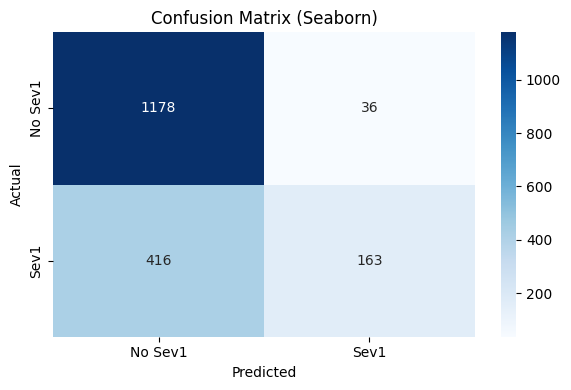

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import plotly.express as px
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score
)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Sev1", "Sev1"], yticklabels=["No Sev1", "Sev1"])
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## **3.4 RESULTS**
###Class 0: No Sev1

* Precision: 0.74
* Recall 0.97
* F1-score: 0.84

###Class 1: Sev1
* Precision: 0.82
* Recall: 0.28
* F1-score: 0.42

###Combined
* Accuracy : 0.75
* Macro avg.  F1-score: 0.63
* Weighted avg. 0.70

**How good the Model is predicting the node will not escalate to Sev1 ?**

* **Precision 74%**: Only about 26% of the time, when the model predicts noSev1, it's wrong. Another way to say is out of all the times the model predicted **"this node with Sev2 is not going to escalate to Sev1", 74% were actually correct**

* **Recall 97%** : The model has a very high recall (0.97): correctly identifies nearly all "safe" Sev2s, ie: Sev2 which never become Sev1

**How good the Model is predicting the node will escalate to Sev1?**

* **Precision 82%**: High prediction: When predicting a Sev1 risk, it's usually right.
* **Recall: 28%** : Low recall the model is missing 72% of the real Sev1s.

This model has mixed results: For one side this model is **very useful for the Support Engineers** because can predict when a Sev2 node will escalate to Sev1 the majority of cases (76%).  This is a **huge improvement** from today when we rely on a very constrained human expertise, which **doesn’t have enough time to review thousands of nodes**.

The bad side is When this model says “this node will not escalate to Sev1, it misses the 72% of the true escalations.

Basically this model is good saying: The node in Sev2 is going to escalate to Sev1 but bad saying this node is not going to escalate to Sev1


**Why is missing 72% of the true Sev1s ?**

The training was done with imbalanced data:

* Macro Av F1-score = 0.63 is the average F1 score of both classes. This means how fair this model treats each class:  this means the data could be imbalanced

* Weighted Average F1-Score = 0.70 takes the F1-score of each class and weights by their support giving a realistic performance score reflecting class imbalance


## 3.5 NEXT STEPS

1. Use model.predict_proba() and test with thresholds < 0.5 (e.g., 0.3). This will make the model more “aggressive” at predicting Sev1.
2. Try tree-based models (Random Forest, XGBoost)
They often handle class imbalance and nonlinear patterns better.
3. Use oversampling (e.g., SMOTE)
To give the model more examples of Class 1 during training.


# 3.6 Appendix

## Challenges at this time**

Key challenges include deal with highly complex data, very large telemetry database,system heterogeneity, and class imbalance. However, the potential benefits are substantial: improving early detection, accelerating mitigation, supporting safe rollout of new technologies, and laying the foundation for AI-assisted observability across the cloud infrastructure.

### Identifying the Right Data Sources**

With over 50 new technology clusters in production across multiple global regions, one of the main challenges was selecting the appropriate data sources. The goal was to find clusters that offered a balanced variety of error types—avoiding extremes of either too much noise or too few issues. It was also critical to ensure:
1. Consistent configuration of firmware and core software components across clusters, to eliminate version-related variability.
2. High-quality telemetry data with easy access through internal databases.
3. At least three months of telemetry history, providing a stable baseline for analysis and making the findings generalizable to similar future deployments.

### Feature Selection and Incident Correlation**

Once data sources were secured, the next step involved identifying the right features that could contribute to Sev1 events. Starting from more than 200 telemetry signals, I consolidated a representative subset of 60 features based on technical intuition and domain expertise. This included a manual review of which Sev2 incidents consistently preceded Sev1 events, not only in terms of timing but also in terms of logical and technical causality. Establishing a meaningful time window was crucial to correctly associate Sev2 warnings with subsequent Sev1 incidents.

### Ensuring Confidentiality**

Given the sensitivity of internal infrastructure and organizational structures, all identifiers—including team names, cluster identifiers, and component labels—were anonymized or replaced with fictitious names. This step ensures full compliance with confidentiality policies while preserving the analytical integrity of the dataset.

### Filtering for Relevant Training Data**
The final step was to filter the dataset to focus only on relevant training samples. This included:
Excluding nodes that did not experience any Sev2 incidents.
Keeping only those NodeId–Severity combinations where at least one Sev2 event occurred before a Sev1.
This filtering allowed the model to learn from meaningful patterns while reducing noise and irrelevant data.